In [130]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from sklearn.decomposition import PCA

from sklearn import metrics

from itertools import cycle

# Show me all of the columns
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

sns.set()
%matplotlib inline

# The Boston Marathon challenge

In [131]:
df = pd.read_csv('https://github.com/llimllib/bostonmarathon/raw/master/results/2014/results.csv')

In [132]:
df.describe(include='all')

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
count,31984,31984,31984.000000,31984,31984,31984.000000,31984.000000,31984,31984.000000,1244,31984,31984.000000,31984.000000,29408,31984,31984,31984,31984,31984,31983,31984
unique,2766,31915,NaN,6570,2,NaN,NaN,31984,NaN,84,9516,NaN,NaN,68,8090,1491,5651,5375,78,5934,10546
top,-,"Williamson, Kelly",NaN,-,M,NaN,NaN,29449,NaN,GBR,-,NaN,NaN,MA,-,23.93,-,-,USA,Boston,-
freq,50,2,NaN,216,17617,NaN,NaN,1,NaN,171,34,NaN,NaN,7587,40,81,72,51,27233,1034,39
mean,NaN,NaN,1932.563032,NaN,NaN,42.407079,242.997314,NaN,8051.044741,NaN,NaN,15939.587825,9.275658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,1715.228694,NaN,NaN,11.316496,52.300431,NaN,4754.005626,NaN,NaN,9232.978224,1.992486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,18.000000,80.600000,NaN,1.000000,NaN,NaN,1.000000,3.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,610.000000,NaN,NaN,33.000000,205.527500,NaN,3972.000000,NaN,NaN,7943.750000,7.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1425.000000,NaN,NaN,42.000000,232.370000,NaN,7970.000000,NaN,NaN,15939.500000,8.870000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2611.000000,NaN,NaN,50.000000,273.235000,NaN,11968.000000,NaN,NaN,23935.250000,10.430000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleanup

Clean up the *k and half columns--they should be numeric data, but contain dashes and numbers expressed as strings: 5k, 10k, 20k, 25k, 30k, 35k, 40k, half

Drop rows where these values have dashes (there are ~300 of these, out of a dataset of ~32,000 rows).

In [133]:
df = df.loc[(df['5k'] != '-') & \
       (df['10k'] != '-') & \
       (df['20k'] != '-') & \
       (df['25k'] != '-') & \
       (df['30k'] != '-') & \
       (df['35k'] != '-') & \
       (df['40k'] != '-') & \
       (df['half'] != '-')]

In [134]:
for splits in ['5k','10k','20k','25k','30k','35k','40k','half']:
#    print(df.loc[df[splits] == '-',splits].value_counts())
    df[splits] = df[splits].astype('float')

Create a new feature: not totally sure what is special about bib numbers that start with "F" besides that they are all women, and possibly that they are the elite runners among women, but let's find out.

In [135]:
df['bibF'] = df['bib'].apply(lambda x: 1 if x.startswith('F') else 0)

In [136]:
df['bibF'].value_counts()

0    31601
1       48
Name: bibF, dtype: int64

Create a new feature: some finishers competed with a wheelchair, denoted by a bib number starting with 'W'.

NOTE: I discovered the wheelchairs and handcycles because I was incredulous about the super fast official times these competitors have. The world record for a marathon is around 2 hours, and most of these times were well below that. I eventually found my way to [the Boston Marathon's own search page for 2014](http://registration.baa.org/2014/cf/Public/iframe_ResultsSearch.cfm?mode=entry), where I was able to plug in some bib numbers. From there everything made sense...

In [137]:
df['wheelchair'] = df['bib'].apply(lambda x: 1 if x.startswith('W') else 0)

In [138]:
df['wheelchair'].value_counts()

0    31596
1       53
Name: wheelchair, dtype: int64

Drop columns we won't care about for clustering purposes, and categorical data that would prove painful to encode: name, bib, city

In [139]:
df.drop(['name','bib','city'],axis='columns',inplace=True)

Encode categorical variables we want to keep: gender, ctz, state, country

In [140]:
df['is_male'] = df['gender'].map(lambda x: 0 if x in 'F' else 1)

In [141]:
df = pd.concat([df,pd.get_dummies(df[['ctz','state','country']])],axis=1)

In [142]:
df.drop(['gender','ctz','state','country'],axis='columns',inplace=True)

Standardize continuous values.

In [143]:
df_norm = pd.DataFrame(normalize(df))

## Finding an optimal number of clusters

In [144]:
df_norm.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,31649.000000,31649.000000,31649.000000,31649.000000,3.164900e+04,31649.000000,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,3.164900e+04,31649.000000,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,31649.000000,3.164900e+04,31649.000000,31649.000000,31649.000000,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,31649.000000,31649.000000,31649.000000,3.164900e+04,31649.000000,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,31649.000000,31649.000000,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900e+04,3.164900

In [145]:
wcss = []
for i in range(1,20):
    kmeans = KMeans(i)
    kmeans.fit(df_norm)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

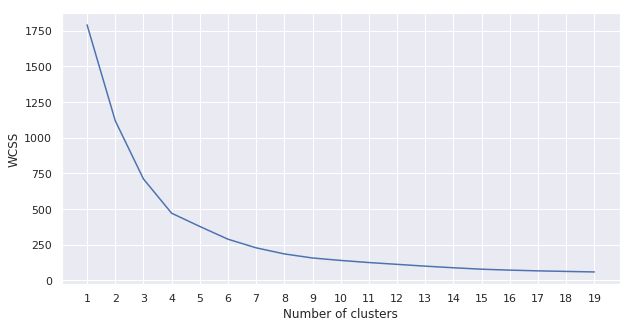

In [146]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20),wcss)
plt.xticks(np.arange(1,20,step=1))
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

## Building a model

The elbow method suggests four clusters. Let's try a basic K-means model with 4 clusters.

In [358]:
km = KMeans(4)
km.fit(df_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [359]:
y_pred = km.predict(df_norm)

In [360]:
y_pred.shape

(31649,)

In [361]:
df.shape

(31649, 247)

In [362]:
# I had to add .reset_index() to df--otherwise, I was getting around 300 rows of NAs with an assigned cluster.
df_clust = pd.concat([df.reset_index(drop=True),pd.Series(y_pred)],axis=1)

In [363]:
df_clust.rename({0: 'cluster'},axis='columns',inplace=True)

In [364]:
df_clust.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,bibF,wheelchair,is_male,ctz_ALG,ctz_ARG,ctz_AUS,ctz_AUT,ctz_BAR,ctz_BEL,ctz_BER,ctz_BIH,ctz_BLR,ctz_BRA,ctz_CAN,ctz_CHI,ctz_CHN,ctz_CMR,ctz_COL,ctz_CPV,ctz_CRC,ctz_CRO,ctz_CZE,ctz_DEN,ctz_DOM,ctz_ECU,ctz_ERI,ctz_ESA,ctz_ESP,ctz_ETH,ctz_FIN,ctz_FRA,ctz_GBR,ctz_GEO,ctz_GER,ctz_GRE,ctz_GUA,ctz_GUY,ctz_HAI,ctz_HKG,ctz_HUN,ctz_IND,ctz_IRI,ctz_IRL,ctz_IRQ,ctz_ISL,ctz_ISR,ctz_ITA,ctz_JPN,ctz_KEN,ctz_KOR,ctz_KSA,ctz_LAT,ctz_LIB,ctz_MAR,ctz_MAS,ctz_MEX,ctz_MLT,ctz_NCA,ctz_NED,ctz_NEP,ctz_NOR,ctz_NZL,ctz_PAK,ctz_PAN,ctz_PAR,ctz_PER,ctz_PHI,ctz_POL,ctz_POR,ctz_ROU,ctz_RSA,ctz_RUS,ctz_SIN,ctz_SLO,ctz_SRI,ctz_SUI,ctz_SVK,ctz_SWE,ctz_TPE,ctz_TRI,ctz_TUR,ctz_UGA,ctz_UKR,ctz_URU,ctz_USA,ctz_VEN,ctz_ZIM,state_AA,state_AB,state_AE,state_AK,state_AL,state_AP,state_AR,state_AZ,state_BC,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MB,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NB,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NL,state_NM,state_NS,state_NT,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PE,state_PR,state_QC,state_RI,state_SC,state_SD,state_SK,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,state_YT,country_ARG,country_AUS,country_AUT,country_BAH,country_BAR,country_BEL,country_BER,country_BLR,country_BOL,country_BRA,country_BRN,country_CAN,country_CAY,country_CHI,country_CHN,country_COL,country_CRC,country_CRO,country_CZE,country_DEN,country_DOM,country_ECU,country_EGY,country_ESA,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GBR,country_GER,country_GRE,country_GUA,country_HKG,country_HUN,country_INA,country_IND,country_IRL,country_ISL,country_ISR,country_ITA,country_JPN,country_KEN,country_KOR,country_LIE,country_LUX,country_MAR,country_MAS,country_MEX,country_NED,country_NOR,country_NZL,country_PAN,country_PER,country_PHI,country_POL,country_POR,country_QAT,country_ROU,country_RSA,country_RUS,country_SIN,country_SLO,country_SUI,country_SVK,country_SWE,country_TAN,country_THA,country_TPE,country_TRI,country_TUR,country_UAE,country_UKR,country_URU,country_USA,country_VEN,country_VGB,country_ZIM,cluster
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.00000,31649.000000,31649.000000,31649.000000,3

So, I have four clusters of...something. How can we understand what these clusters look like?

I thought about treating cluster as a target variable, to see what is most highly correlated with it.

In [384]:
clust_corr = df_clust.corr()

In [385]:
clust_corr['cluster'].sort_values(ascending=False).head(20)

cluster        1.000000
is_male        0.860664
wheelchair     0.136627
bibF           0.070592
country_KEN    0.055654
country_ETH    0.045936
state_QC       0.030480
country_ESP    0.027930
country_THA    0.026519
country_NED    0.025857
country_GBR    0.025797
ctz_ECU        0.024523
country_RUS    0.024429
state_IL       0.024364
country_ITA    0.024000
state_NY       0.022388
country_IRL    0.022262
country_CHN    0.021969
country_SLO    0.021305
country_AUS    0.021092
Name: cluster, dtype: float64

The features I created, wheelchair and bibF, are both here, but I don't think the model actually used them.

Spoiler alert: the model appears to heavily favor gender, age, and official time as the three main factors. It does seem to recognize the wheelchair competitors as belonging together, however!

## Visualizations

I thought I'd try using PCA to reduce the data to two variables that I can plot. Here's how that looks.

In [365]:
clust_PCA = PCA(2).fit_transform(df_norm)

In [366]:
clust_PCA = pd.concat([pd.DataFrame(clust_PCA),pd.Series(y_pred)],axis=1)

In [367]:
clust_PCA.columns = ['pca1','pca2','cluster']

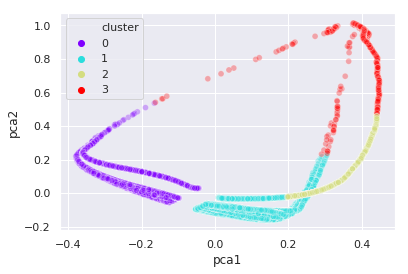

In [368]:
sns.scatterplot('pca1','pca2',data=clust_PCA,hue='cluster',palette='rainbow',alpha=.3)

This PCA plot has to be one of the weirdest-looking distributions I've ever seen. I don't feel like it tells us much, but the really clean delineation between the four clusters is promising.

## The clusters, plotted using their most significant features: official time, age, and gender

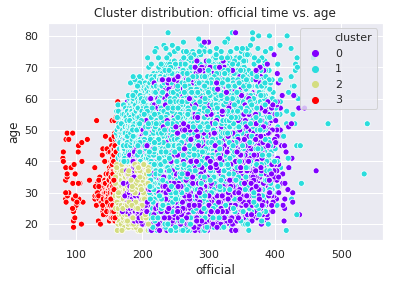

In [371]:
ax = sns.scatterplot('official','age',data=df_clust,
                hue='cluster',
                palette='rainbow').set_title('Cluster distribution: official time vs. age')

Official time is a clear factor for clusters 2 and 3:

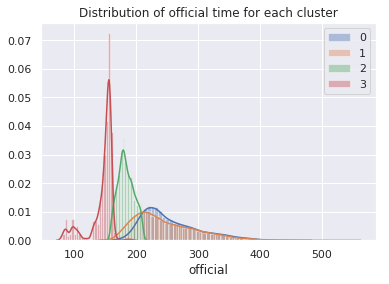

In [369]:
for c in range(0,(df_clust['cluster'].max()+1)):
    fig=plt.figure
    ax = sns.distplot(df_clust.loc[df_clust['cluster'] == c,'official'],label=c)
    ax.set_title("Distribution of official time for each cluster")
    ax.legend()

Age appears to be the other major factor, for Cluster 2 at least--it has a pretty tight distribution, and no outliers.

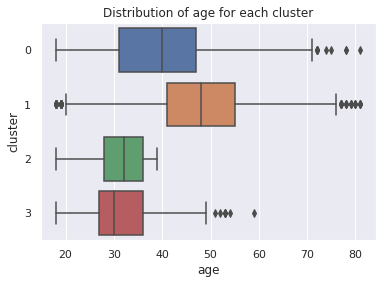

In [392]:
ax = sns.boxplot(y='cluster',x='age',data=df_clust,orient='h').set_title('Distribution of age for each cluster')

Gender is the third major factor for these clusters. Only Cluster 3 has both women and men.

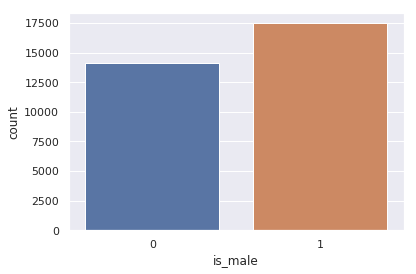

In [413]:
sns.countplot(df_clust['is_male'])

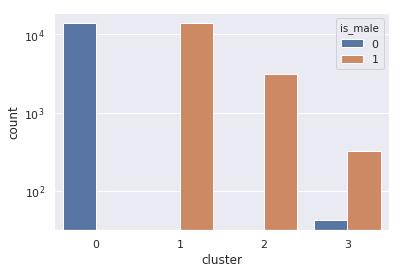

In [411]:
g = sns.countplot(x='cluster',hue='is_male',data=df_clust)

g.set_yscale('log')

### I'm calling Cluster 3 'wheels and elites'--their fast official times are their primary shared feature.

The fastest runner in 2014 finished in 2 hours, 8 minutes. Anyone with a faster official time was using a wheelchair, or a handcycle. (Oddly, handcycles do not have a unique set of bibs like the wheelchair competitors, so I wasn't able to create a feature for them.)

Note that there is a cutoff around 160 minutes for the runners, but all 53 of the wheelchair competitors were placed in this cluster regardless of official time.

In [372]:
df_c3 = df_clust.loc[(df_clust['cluster'] == 3)]

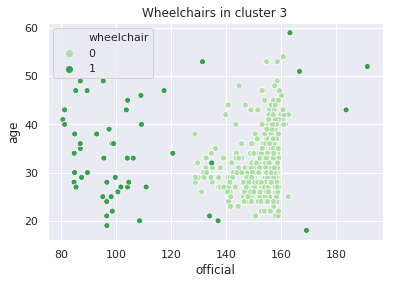

In [373]:
ax = sns.scatterplot('official','age',data=df_c3,
                    hue='wheelchair',palette='Greens').set_title('Wheelchairs in cluster 3')

This cluster is mostly, but not entirely, male.

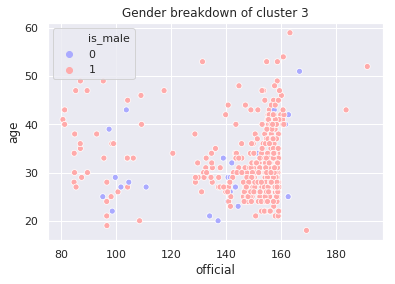

In [374]:
ax = sns.scatterplot('official','age',data=df_c3,
                    hue='is_male',palette='bwr').set_title('Gender breakdown of cluster 3')

Cluster 3 includes most of the women whose bib numbers start with 'F', though interestingly, not all. Their official times seem to be the deciding factor, with a cutoff of 165-ish minutes. The rest of the F-bib women were grouped into Cluster 0.

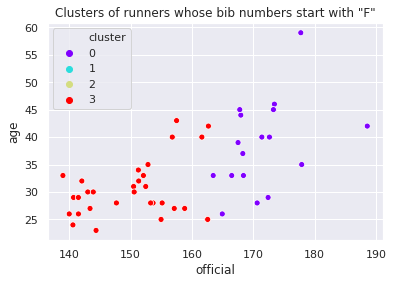

In [375]:
ax = sns.scatterplot('official','age',data=df_clust.loc[df_clust['bibF'] == 1],
                hue='cluster',
                palette='rainbow').set_title('Clusters of runners whose bib numbers start with "F"')

### Cluster 2 appears to be 'fast younger guys'--entirely male, age 0-39.

They are not as fast as the elite runners, but they are competitive.

It's really interesting to me that this cluster is as tight as it is, in terms of being bounded by both official time and age.

In [376]:
df_c2 = df_clust.loc[(df_clust['cluster'] == 2)]

In [377]:
df_c2['is_male'].value_counts()

1    3105
Name: is_male, dtype: int64

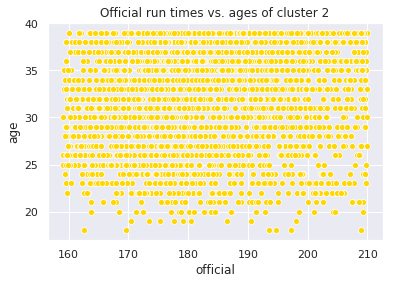

In [378]:
ax = sns.scatterplot('official','age',data=df_c2,
                color='gold').set_title('Official run times vs. ages of cluster 2')

### Cluster 1: All of the other men.

This cluster is all of the men who were not among the elite Cluster 3, or the faster, younger Cluster 2.

In [379]:
df_c1 = df_clust.loc[df_clust['cluster'] == 1]

In [380]:
df_c1['is_male'].value_counts()

1    14051
Name: is_male, dtype: int64

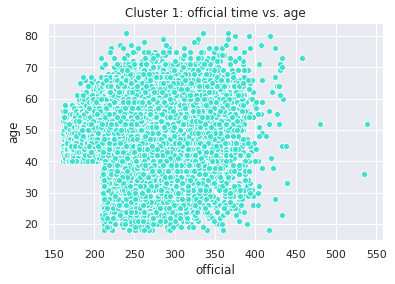

In [381]:
ax = sns.scatterplot('official','age',data=df_c1,color='turquoise').set_title('Cluster 1: official time vs. age')

### Cluster 0: All of the other women.

This cluster is all of the women who were not in the elite Cluster 3. That's it.

In [382]:
df_c0 = df_clust.loc[df_clust['cluster'] == 0]

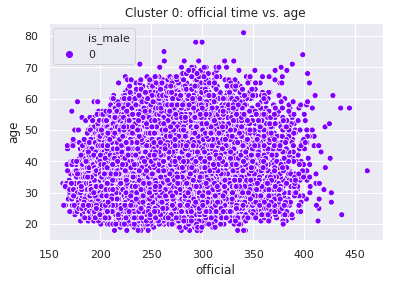

In [383]:
ax = sns.scatterplot('official','age',data=df_c0,
                hue='is_male',
                palette='rainbow').set_title('Cluster 0: official time vs. age')

### To be sure I had an optimal number of clusters, I tried increasing the number I fed to KMeans from 4 to 5, and 6. 
The new clusters were subdivisions of the existing ones, along the same age/official time/gender lines that defined the four clusters I have. One additional cluster contained men who ran within the same range of time as the Fast Younger Guys, but who were 40 and older. Another was a similar subdivision of the women who are grouped together in Cluster 0.